In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from faker import Faker
import matplotlib.pyplot as plt


*Simulate Retail Data*

Products & Categories

In [2]:
fake = Faker()
np.random.seed(42)

num_products = 300
product_ids = [f"P{str(i).zfill(4)}" for i in range(1, num_products+1)]
categories = ['Electronics', 'FMCG', 'Apparel', 'Home & Kitchen', 'Sports', 'Books']

products_df = pd.DataFrame({
    'Product_ID': product_ids,
    'Product_Category': np.random.choice(categories, size=num_products)
})


Sales Data

In [3]:
num_stores = 15
store_ids = [f"S{str(i).zfill(3)}" for i in range(1, num_stores+1)]

date_range = pd.date_range("2025-01-01", "2025-12-31")

sales_rows = []
for date in date_range:
    for _ in range(np.random.randint(50, 100)):
        sales_rows.append([
            date.strftime("%Y-%m-%d"),
            random.choice(product_ids),
            random.choice(store_ids),
            np.random.randint(1, 20),
            round(np.random.uniform(10, 500), 2)
        ])

sales_df = pd.DataFrame(
    sales_rows,
    columns=['Date', 'Product_ID', 'Store_ID', 'Units_Sold', 'Unit_Price']
)


Inventory Data

In [4]:
inventory_rows = []
for pid, cat in zip(product_ids, products_df['Product_Category']):
    inventory_rows.append([
        pid,
        cat,
        np.random.randint(50, 500),
        np.random.randint(20, 100),
        np.random.randint(3, 15),
        fake.company()
    ])

inventory_df = pd.DataFrame(
    inventory_rows,
    columns=['Product_ID','Product_Category','Stock_Level',
             'Reorder_Level','Lead_Time_Days','Supplier']
)


Operations Data

In [5]:
operations_rows = []
order_id = 100000

for _, row in sales_df.iterrows():
    order_id += 1
    order_date = datetime.strptime(row['Date'], "%Y-%m-%d")
    duration = np.random.randint(1, 10)

    if random.random() < 0.08:
        duration += np.random.randint(1, 5)
        status = 'Delayed'
    else:
        status = 'Completed'

    operations_rows.append([
        order_id,
        row['Product_ID'],
        order_date.strftime("%Y-%m-%d"),
        (order_date + timedelta(days=duration)).strftime("%Y-%m-%d"),
        duration,
        status
    ])

operations_df = pd.DataFrame(
    operations_rows,
    columns=['Order_ID','Product_ID','Order_Date',
             'Delivery_Date','Process_Duration_Days','Status']
)


*Basic EDA*

In [7]:
sales_df.head()


,Date,Product_ID,Store_ID,Units_Sold,Unit_Price
0,2025-01-01,P0093,S014,3,487.10
1,2025-01-01,P0073,S009,18,88.80
2,2025-01-01,P0136,S007,18,247.95
3,2025-01-01,P0047,S002,3,329.46
4,2025-01-01,P0104,S009,9,96.20


In [14]:
products_df.head()

,Product_ID,Product_Category
0,P0001,Home & Kitchen
1,P0002,Sports
2,P0003,Apparel
3,P0004,Sports
4,P0005,Sports


In [15]:
inventory_df.head()

,Product_ID,Product_Category,Stock_Level,Reorder_Level,Lead_Time_Days,Supplier
0,P0001,Home & Kitchen,74,34,12,Bell LLC
1,P0002,Sports,408,96,7,Farrell PLC
2,P0003,Apparel,409,84,3,Nelson LLC
3,P0004,Sports,428,73,9,Reyes and Sons
4,P0005,Sports,255,58,5,Wong-Rivera


In [16]:
operations_df.head()

,Order_ID,Product_ID,Order_Date,Delivery_Date,Process_Duration_Days,Status
0,100001,P0093,2025-01-01,2025-01-04,3,Completed
1,100002,P0073,2025-01-01,2025-01-09,8,Completed
2,100003,P0136,2025-01-01,2025-01-06,5,Completed
3,100004,P0047,2025-01-01,2025-01-07,6,Completed
4,100005,P0104,2025-01-01,2025-01-04,3,Completed


In [6]:
sales_df.shape
sales_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27372 entries, 0 to 27371
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        27372 non-null  object 
 1   Product_ID  27372 non-null  object 
 2   Store_ID    27372 non-null  object 
 3   Units_Sold  27372 non-null  int64  
 4   Unit_Price  27372 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.0+ MB


In [8]:
sales_df.isnull().sum()


Date          0
Product_ID    0
Store_ID      0
Units_Sold    0
Unit_Price    0
dtype: int64

In [9]:
sales_df.describe()


,Units_Sold,Unit_Price
count,27372.000000,27372.000000
mean,10.046580,255.346262
std,5.461118,141.811095
min,1.000000,10.010000
25%,5.000000,132.517500
50%,10.000000,255.105000
75%,15.000000,378.682500
max,19.000000,499.990000


*START SQL*

Create an sql database

In [10]:
import sqlite3

In [11]:
conn = sqlite3.connect('retail_analytics.db')

Push DataFrames → SQL Tables

In [12]:
products_df.to_sql("products", conn, if_exists="replace", index=False)
sales_df.to_sql("sales", conn, if_exists="replace", index=False)
inventory_df.to_sql("inventory", conn, if_exists="replace", index=False)
operations_df.to_sql("operations", conn, if_exists="replace", index=False)


27372

*SQL BUSINESS ANALYSIS*

Revenue by Category


In [13]:
query = """
SELECT 
    p.Product_Category,
    ROUND(SUM(s.Units_Sold * s.Unit_Price), 2) AS Total_Revenue
FROM sales s
JOIN products p
ON s.Product_ID = p.Product_ID
GROUP BY p.Product_Category
ORDER BY Total_Revenue DESC;
"""
pd.read_sql(query, conn)


,Product_Category,Total_Revenue
0,Home & Kitchen,15222544.60
1,Electronics,12845678.28
2,Apparel,12219857.80
3,Books,10835981.69
4,FMCG,9989365.35
5,Sports,9043954.43


Top 10 Revenue Products

In [23]:
query = """
SELECT Product_ID,
       SUM(Units_Sold * Unit_Price) AS Revenue
FROM sales
GROUP BY Product_ID
ORDER BY Revenue DESC
LIMIT 10;
"""

pd.read_sql(query, conn)


,Product_ID,Revenue
0,P0241,330621.31
1,P0104,330342.55
2,P0010,330192.04
3,P0133,330117.92
4,P0298,316528.83
5,P0185,316119.98
6,P0253,305515.95
7,P0061,303367.13
8,P0126,299432.57
9,P0296,299030.26


Store Performance

In [24]:
query = """
SELECT Store_ID,
       SUM(Units_Sold * Unit_Price) AS Store_Revenue
FROM sales
GROUP BY Store_ID
ORDER BY Store_Revenue DESC;
"""

pd.read_sql(query, conn)

,Store_ID,Store_Revenue
0,S010,4883972.19
1,S005,4865569.89
2,S011,4837330.34
3,S009,4776318.03
4,S007,4775778.92
5,S003,4737113.60
6,S002,4721505.52
7,S014,4701638.73
8,S013,4647238.74
9,S006,4591327.41


Order Delay Rate

In [30]:
query="""
SELECT 
    Status,
    COUNT(*) * 100.0 / (SELECT COUNT(*) FROM operations) AS Percentage
FROM operations
GROUP BY Status;
"""
pd.read_sql(query,conn)

,Status,Percentage
0,Completed,92.214672
1,Delayed,7.785328


*PYTHON ANALYSIS*

Daily Revenue Trend

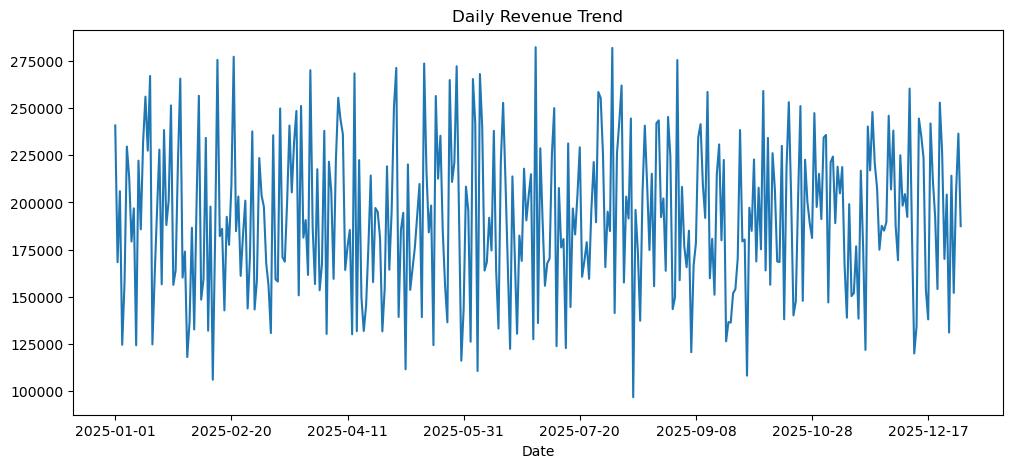

In [31]:
sales_df['Revenue'] = sales_df['Units_Sold'] * sales_df['Unit_Price']
daily_revenue = sales_df.groupby('Date')['Revenue'].sum()

plt.figure(figsize=(12,5))
daily_revenue.plot()
plt.title("Daily Revenue Trend")
plt.show()


Inventory Risk Analysis

In [32]:
inventory_df['Stock_Risk'] = np.where(
    inventory_df['Stock_Level'] < inventory_df['Reorder_Level'],
    'High Risk',
    'Normal'
)

inventory_df['Stock_Risk'].value_counts()


Normal       293
High Risk      7
Name: Stock_Risk, dtype: int64

Demand Forecasting

In [33]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

C:\Users\hitha sunil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\hitha sunil\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


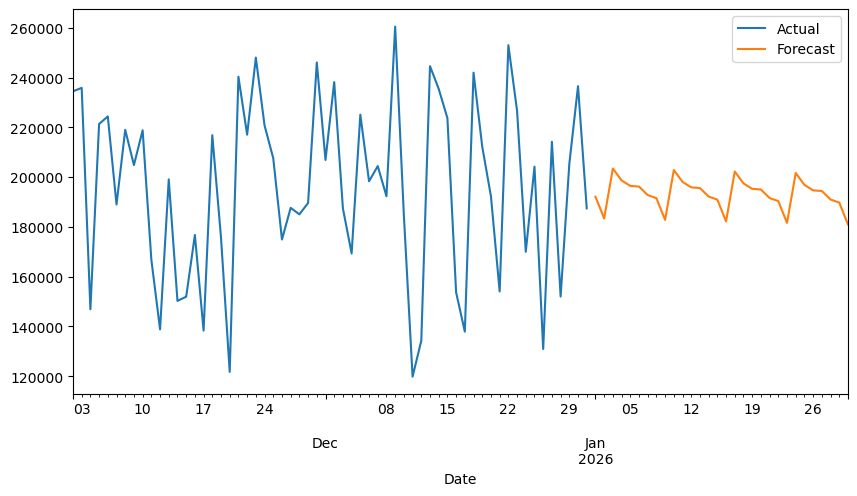

In [34]:
daily_revenue.index = pd.to_datetime(daily_revenue.index)

model = ExponentialSmoothing(
    daily_revenue,
    trend='add',
    seasonal='add',
    seasonal_periods=7
).fit()

forecast = model.forecast(30)

plt.figure(figsize=(10,5))
daily_revenue[-60:].plot(label='Actual')
forecast.plot(label='Forecast')
plt.legend()
plt.show()

In [35]:
final_df = pd.merge(
    sales_df,
    products_df,
    on='Product_ID',
    how='left'
)

final_df.to_csv("final_retail_data.csv", index=False)


In [36]:
# Merge sales + products
bi_sales = sales_df.merge(products_df, on='Product_ID', how='left')

# Merge inventory
bi_sales = bi_sales.merge(
    inventory_df[['Product_ID','Stock_Level','Reorder_Level']],
    on='Product_ID',
    how='left'
)

# Merge operations
bi_sales = bi_sales.merge(
    operations_df[['Order_ID','Product_ID','Status']],
    on='Product_ID',
    how='left'
)

# Create revenue column
bi_sales['Revenue'] = bi_sales['Units_Sold'] * bi_sales['Unit_Price']

bi_sales.to_csv("retail_powerbi_data.csv", index=False)
